In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from nice.algorithms.connectivity import epochs_compute_wsmi
import mne
import warnings
warnings.filterwarnings("ignore")
from scipy.ndimage import gaussian_filter1d

import pyinform as pi


def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds.astype(float) > 1e-6    #finds the time points where std is not 0
    const_cols = stds.astype(float) <= 1e-6    #finds the time points where std is 0

    z = np.zeros_like(data[:, :])   #creates an array of zeros with the same shape as the data
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)  #in the columns where std is not 0, zscores the data
    z[:, const_cols] = np.mean(data[:, const_cols], axis=0)

 
    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

wsmi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
wsmi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}


total_time = time.time()
def collect_data(sigma = 2):
    epochs_data = {'left': [], 'right': []}
    for file_number in  file_numbers:
        file_total = time.time()
        file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
        load_data_start_time = time.time()
        data = pickle.load(open(file_path, 'rb'))
        elapsed_time = time.time() - load_data_start_time
        print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

        attention_labels = data['label_attend'][0]
        label_left = data['label_left'][0]
        label_right = data['label_right'][0]
        attend_01 = data['attend'][0]
        omitted = data['omit'][0]
        relevant = np.where(omitted ==0)[0]
    
        left_input_SP = data['SP'][0][0][relevant]
        right_input_SP = data['SP'][0][1][relevant]
        attention_SP = data['SP'][0][2][relevant]

        left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
        right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
        att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

        num_trials, num_samples, num_neurons = left_input_SP.shape
        num_neurons_attention = 80

                
        for j in range(0, num_trials):
            for i in range(0, num_neurons):
                count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
                if count_left > 0:
                    left_sm[j, :, i] /= count_left
                count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
                if count_right > 0:
                    right_sm[j, :, i] /= count_right


            for i in range(0, num_neurons_attention):
                count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
                if count_attention > 0:
                    att_sm[j, :, i] /= count_attention


        left_input_SP = np.sum(left_sm, axis=2)
        right_input_SP = np.sum(right_sm, axis=2)
        attention_SP = np.sum(att_sm, axis=2)

        left_input_SP = preprocess(left_input_SP)
        right_input_SP = preprocess(right_input_SP)
        attention_SP = preprocess(attention_SP)

        #preprocess here now that we have traces of all of the relavant trials
        left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
        _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
        right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
        _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

        #splitting left and right
        left_input_SP_attleft = left_input_SP[left_indices, 100:350]
        right_input_SP_attleft = right_input_SP[left_indices, 100:350]
        attention_SP_attleft = attention_SP[left_indices, 100:350]

        left_input_SP_attright = left_input_SP[right_indices, 100:350]
        right_input_SP_attright = right_input_SP[right_indices, 100:350]
        attention_SP_attright = attention_SP[right_indices, 100:350]


        #----------------------------------------------------------------
        sfreq = 500.0
        ch_names = ['left_input', 'right_input', 'attention_layer']
        ch_types = ['eeg', 'eeg', 'eeg']
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


        data_left = np.stack([
            left_input_SP_attleft, 
            right_input_SP_attleft, 
            attention_SP_attleft 
        ], axis=1) 
        print(data_left.shape)

        epochs_left = mne.EpochsArray(
            data_left,
            info, 
            tmin=0, 
            baseline=None
        )

        data_right = np.stack([
            left_input_SP_attright,
            right_input_SP_attright,
            attention_SP_attright
        ], axis=1) 

        epochs_right = mne.EpochsArray(
            data_right,
            info,
            tmin=0,
            baseline=None
        )

        epochs_data['left'].append(epochs_left)
        epochs_data['right'].append(epochs_right)
    #----------------------------------------------------------------
    
        del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
        gc.collect()
        del(data)
        gc.collect()
        print(f'Dataset {file_number} complete in', time.time() - file_total)

    print('total time elapsed =', time.time() - total_time)
    return epochs_data



c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [2]:
epochs_data = collect_data(4)

Dataset 1 loaded in 8.71 seconds
(495, 3, 250)
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Dataset 1 complete in 28.325023889541626
Dataset 2 loaded in 13.87 seconds
(488, 3, 250)
Not setting metadata
Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
502 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Dataset 2 complete in 30.932055711746216
Dataset 4 loaded in 9.07 seconds
(496, 3, 250)
Not setting metadata
Not setting metadata
496 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not settin

In [3]:
import numpy as np
from pyinform import transfer_entropy

def discretize(ts, n_states=6):
    """
    Equal-frequency bins → states 0..n_states-1.
    """
    # Compute quantile edges at [0, 1/n_states, 2/n_states, ..., 1]
    qs = np.linspace(0, 1, n_states + 1)
    edges = np.quantile(ts, qs)
    # Digitize: values in bin i → i, so final states are 0..n_states-1
    return np.digitize(ts, edges[1:-1], right=True).astype(int)


def epoch_te_stats(epochs, src_idx, tgt_idx, k=3, n_states=6):
    data = epochs.get_data()                  
    n_trials, _, n_times = data.shape
    if n_times <= k:
        raise ValueError(f"Not enough time points ({n_times}) for k={k}")


    te_vals = np.zeros(n_trials, float)
    for ti in range(n_trials):
        # 1) extract continuous time-series
        xs_cont = data[ti, src_idx, :]
        ys_cont = data[ti, tgt_idx, :]
        # 2) discretize to small integer alphabet
        xs = discretize(xs_cont, n_states=n_states).tolist()
        ys = discretize(ys_cont, n_states=n_states).tolist()
        # 3) compute TE (apparent, no conditioning)
        te_vals[ti] = transfer_entropy(xs, ys, k=k)

    return te_vals.mean(), te_vals.std(ddof=1)



def TE_calc(k_vals = [3, 6, 9, 12], n_states = 12):
    te_means = {k: {n: {'left_attleft': [], 'right_attleft': [], 
                             'left_attright': [], 'right_attright': []}
            for n in file_numbers} for k in k_vals}
    te_stdevs = {k: {n: {'left_attleft': [], 'right_attleft': [], 
                              'left_attright': [], 'right_attright': []}
             for n in file_numbers} for k in k_vals}
    for k in k_vals:
        for idx, file_number in enumerate(file_numbers):
            total_time = time.time()
            key = file_number
            epochs_left  = epochs_data['left'][idx]
            epochs_right = epochs_data['right'][idx]

            #left - att left
            mean_la, std_la = epoch_te_stats(epochs_left,  src_idx=0, tgt_idx=2, k=k, n_states=n_states)
            #right - att left
            mean_ra, std_ra = epoch_te_stats(epochs_left,  src_idx=1, tgt_idx=2, k=k, n_states=n_states)
            #left - attright
            mean_lb, std_lb = epoch_te_stats(epochs_right, src_idx=0, tgt_idx=2, k=k, n_states=n_states)
            #right - attright
            mean_rb, std_rb = epoch_te_stats(epochs_right, src_idx=1, tgt_idx=2, k=k, n_states=n_states)

            # store results
            te_means[k][key]['left_attleft'].append(mean_la)
            te_means[k][key]['right_attleft'].append(mean_ra)
            te_means[k][key]['left_attright'].append(mean_lb)
            te_means[k][key]['right_attright'].append(mean_rb)

            te_stdevs[k][key]['left_attleft'].append(std_la)
            te_stdevs[k][key]['right_attleft'].append(std_ra)
            te_stdevs[k][key]['left_attright'].append(std_lb)
            te_stdevs[k][key]['right_attright'].append(std_rb)

            print(f"Dataset {file_number} TE calculated for k={k} in {time.time() - total_time:.2f} seconds")

    return te_means, te_stdevs


In [4]:
te_means, te_stdevs = TE_calc(k_vals=[1, 2, 3, 4, 5, 6], n_states = 10)

Dataset 1 TE calculated for k=1 in 1.62 seconds
Dataset 2 TE calculated for k=1 in 1.05 seconds
Dataset 4 TE calculated for k=1 in 1.09 seconds
Dataset 8 TE calculated for k=1 in 1.15 seconds
Dataset 14 TE calculated for k=1 in 1.02 seconds
Dataset 15 TE calculated for k=1 in 1.21 seconds
Dataset 20 TE calculated for k=1 in 1.32 seconds
Dataset 23 TE calculated for k=1 in 1.11 seconds
Dataset 1 TE calculated for k=2 in 2.57 seconds
Dataset 2 TE calculated for k=2 in 2.10 seconds
Dataset 4 TE calculated for k=2 in 1.47 seconds
Dataset 8 TE calculated for k=2 in 3.61 seconds
Dataset 14 TE calculated for k=2 in 40.55 seconds
Dataset 15 TE calculated for k=2 in 3.43 seconds
Dataset 20 TE calculated for k=2 in 1.83 seconds
Dataset 23 TE calculated for k=2 in 1.67 seconds
Dataset 1 TE calculated for k=3 in 1.60 seconds
Dataset 2 TE calculated for k=3 in 1.71 seconds
Dataset 4 TE calculated for k=3 in 1.30 seconds
Dataset 8 TE calculated for k=3 in 1.59 seconds
Dataset 14 TE calculated for k=

In [10]:
k_vals       = [1, 2, 3, 4, 5, 6]
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

# prepare lists of 8 values per k
te_in  = {k: [] for k in k_vals}
te_out = {k: [] for k in k_vals}

for k in k_vals:
    for i in file_numbers:
        # average the two “in” conditions for this te_meansset
        v_in  = (te_means[k][i]['left_attleft'][0]
                 + te_means[k][i]['right_attright'][0]) / 2
        # average the two “out” conditions
        v_out = (te_means[k][i]['left_attright'][0]
                 + te_means[k][i]['right_attleft'][0]) / 2

        te_in[k].append(v_in)
        te_out[k].append(v_out)

# Now te_in[k] and te_out[k] are lists of length 8 each


In [11]:
def plot_te(in_dict, out_dict, ks=None, width=0.35):
    # If no explicit order given, use the dict's insertion order
    if ks is None:
        ks = list(in_dict.keys())
    n = len(ks)
    x = np.arange(n)

    # Collect data in the specified order
    data_in  = [in_dict[b] for b in k_vals]
    data_out = [out_dict[b] for b in k_vals]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Boxplots: In at x-width/2, Out at x+width/2
    bp_in  = ax.boxplot(data_in,
                        positions=x - width/2,
                        widths=width,
                        notch=False,
                        patch_artist=True,
                        boxprops=dict(facecolor='C0', alpha=0.6),
                        medianprops=dict(color='k'))
    bp_out = ax.boxplot(data_out,
                        positions=x + width/2,
                        widths=width,
                        notch=False,
                        patch_artist=True,
                        boxprops=dict(facecolor='C1', alpha=0.6),
                        medianprops=dict(color='k'))

    ax.set_xticks(x)
    ax.set_xticklabels(ks)
    ax.set_xlabel('k value')
    ax.set_ylabel('Transfer Entropy')
    ax.set_title('Transfer Entropy vs k (In vs Out)')

    # Legend
    ax.legend([bp_in["boxes"][0], bp_out["boxes"][0]],
              ['In', 'Out'],
              loc='upper right',
              fontsize=16)

    plt.tight_layout()
    plt.show()


In [12]:
print(te_means)

{1: {1: {'left_attleft': [np.float64(0.32273475024005926)], 'right_attleft': [np.float64(0.3282314459581989)], 'left_attright': [np.float64(0.34930208590193274)], 'right_attright': [np.float64(0.3417897240942605)]}, 2: {'left_attleft': [np.float64(0.3411104567273366)], 'right_attleft': [np.float64(0.34867761018034604)], 'left_attright': [np.float64(0.3486406892437013)], 'right_attright': [np.float64(0.34898020192185053)]}, 4: {'left_attleft': [np.float64(0.3485500957963254)], 'right_attleft': [np.float64(0.3509740765085932)], 'left_attright': [np.float64(0.34331624991950965)], 'right_attright': [np.float64(0.34852530352625116)]}, 8: {'left_attleft': [np.float64(0.38788817765044986)], 'right_attleft': [np.float64(0.3887721113333036)], 'left_attright': [np.float64(0.37174728536276175)], 'right_attright': [np.float64(0.3720473396028497)]}, 14: {'left_attleft': [np.float64(0.34774930424297823)], 'right_attleft': [np.float64(0.3385370905541787)], 'left_attright': [np.float64(0.3225144064349

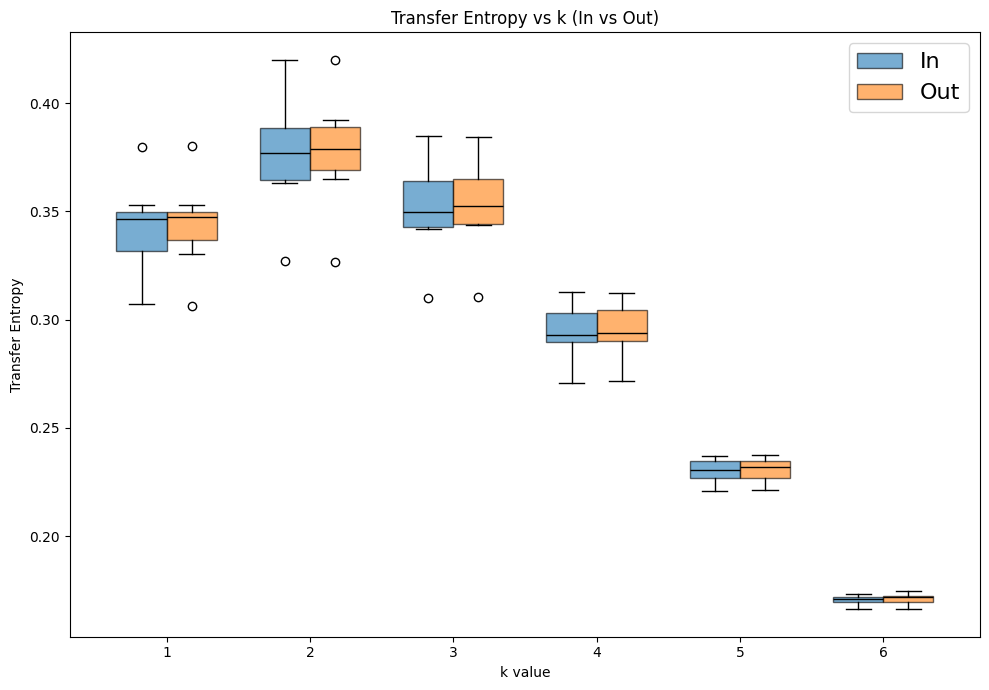

In [13]:
plot_te(te_in, te_out, k_vals)
#the following is for 6 bins